In [1]:
# YOLOv7
%load_ext autoreload
%autoreload 2

In [6]:
# Change directory to download dataset into that folder
cd '/Users/huntersylvester/Desktop/UMMC/Research/Moradi/xmlfolder1/'

/Users/huntersylvester/Desktop/UMMC/Research/Moradi/xmlfolder1


Selecting Dataset

In [7]:
# Import libraries needed
from pathlib import Path
import sys
import os 
import glob 
import pickle
import pandas as pd
import xml.etree.ElementTree as ET
from os import listdir, getcwd
from os.path import join

In [5]:
# !pip install roboflow
# Download faux dataset to make sure this works
# It is in same format as our actual images and annotations (XML format) and knee images
# This will create new folder called kneeJoint-1 in directory
from roboflow import Roboflow
rf = Roboflow(api_key="FooBar")
project = rf.workspace("none-d23ce").project("kneejoint")
dataset = project.version(1).download("voc")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to kneeJoint-1 in voc:: 100%|██████████| 105/105 [00:00<00:00, 2856.53it/s]


In [30]:
# Set paths so all will work accordingly
data_path = '../kneeJoint-1'
data_path = Path(data_path)
images_path = data_path / 'train'
annotations_file_path = data_path / 'out.csv'

In [25]:
# Directory should be in folder before images and labels: '/Users/huntersylvester/Desktop/UMMC/Research/Moradi/xmlfolder/kneeJoint-1'
cd ../xmlfolder1/kneeJoint-1/

/Users/huntersylvester/Desktop/UMMC/Research/Moradi/xmlfolder1/kneeJoint-1


In [28]:
# Converts XML info to YOLO txt files to create data frames in upcoming steps

# If you have test or more classes can always include below
dirs = ['train', 'valid']
classes = ['KneeJoint']

def getImagesInDir(dir_path):
    image_list = []
    for filename in glob.glob(dir_path + '/*.jpg'):
        image_list.append(filename)

    return image_list

# This provides center x,y width and height
# def convert(size, box):
#     dw = 1./(size[0])
#     dh = 1./(size[1])
#     x = (box[0] + box[1])/2.0 - 1
#     y = (box[2] + box[3])/2.0 - 1
#     w = box[1] - box[0]
#     h = box[3] - box[2]
#     x = x*dw
#     w = w*dw
#     y = y*dh
#     h = h*dh
#     return (x,y,w,h)

# This just gives xmin, ymin, etc. 
def convert(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    xmin = box[0]
    xmax = box[1]
    ymin = box[2] 
    ymax = box[3]

    return (xmin,xmax,ymin,ymax)
    

def convert_annotation(dir_path, output_path, image_path):
    basename = os.path.basename(image_path)
    basename_no_ext = os.path.splitext(basename)[0]

    in_file = open(dir_path + '/' + basename_no_ext + '.xml')
    out_file = open(output_path + basename_no_ext + '.txt', 'w')
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        bb = convert((w,h), b)
        out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')
        
cwd = getcwd()

In [29]:
# This feeds files into functions in previous cell 
for dir_path in dirs:
    full_dir_path = cwd + '/' + dir_path
    output_path = full_dir_path +'/yolo/'

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    image_paths = getImagesInDir(full_dir_path)
    list_file = open(full_dir_path + '.txt', 'w')

    for image_path in image_paths:
        list_file.write(image_path + '\n')
        convert_annotation(full_dir_path, output_path, image_path)
    list_file.close()

    print("Finished processing: " + dir_path)

Finished processing: train
Finished processing: valid


In [87]:
# May get errors so use to delete ipynb.checkpoint 
# ls -l train/yolo/
# rm -rf find -type d -name .ipynb_checkpoints
# cd '/Users/huntersylvester/Desktop/UMMC/Research/Moradi/xmlfolder/kneeJoint-1'

NameError: name 'pwd' is not defined

In [34]:
# Creates dataframe to save
# Must change path to yolo folder now
cwd = getcwd()
folder_path = cwd + '/train/yolo' 
folder_path
# folder_path = "/Users/huntersylvester/Desktop/UMMC/Research/Moradi/xmlfolder1/kneeJoint-1/train/yolo"
list1 = []

for fldr in os.listdir(folder_path): # 91c36b72-9117692L_png.rf.8c2578579a76e03acc7102a2f4066a52.txt
    y = fldr.split('.txt')[0] # 91c36b72-9117692L_png.rf.8c2578579a76e03acc7102a2f4066a52
    x = "train/yolo/" + fldr
    with open(x) as f:
        for line in f:
            j = line.strip('\n').split(' ') # ['0', '0.5109375', '0.51953125', '0.92578125', '0.28359375']
            j.append(y)
            list1.append(j)
df = pd.DataFrame(list1, columns=['label', 'xmin', 'xmax', 'ymin', 'ymax', 'image'])

# Either way below works
df.label[df.label=='0'] = 'KneeJoint'
# df.label[df.label=='0'] = df['label'].map({0:'KneeJoint'})

In [35]:
df.head()

,label,xmin,xmax,ymin,ymax,image
0,KneeJoint,32.0,624.0,243.0,424.0,91c36b72-9117692L_png.rf.8c2578579a76e03acc710...
1,KneeJoint,15.0,629.0,255.0,476.0,17a1cfc4-9137393L_png.rf.39f1925c6e27e8e7eb515...
2,KneeJoint,29.0,631.0,283.0,471.0,0536e778-9063934L_png.rf.8d064bf04436c1094cf2e...
3,KneeJoint,23.0,600.0,267.0,459.0,285b47ae-9117692R_png.rf.20c211ed86651dcbfbf9e...
4,KneeJoint,20.0,618.0,200.0,443.0,674575c7-9146801R_png.rf.7ccbc99ef591ae898ba7e...


In [36]:
# Need to save file as a csv
# set directory beforehand
df.to_csv('/Users/huntersylvester/Desktop/UMMC/Research/Moradi/xmlfolder1/kneeJoint-1/out.csv')
# df.to_csv('out.csv',)

In [37]:
import random 
def load_cars_df(annotations_file_path, images_path):
    all_images = sorted(set([p.parts[-1] for p in images_path.iterdir()]))
    image_id_to_image = {i: im for i, im in enumerate(all_images)}
    image_to_image_id = {v: k for k, v, in image_id_to_image.items()}

    annotations_df = pd.read_csv(annotations_file_path)
    annotations_df.loc[:, "class_name"] = "kneejoint"
    annotations_df.loc[:, "has_annotation"] = True

    # add 10 empty images to the dataset
#     empty_images = sorted(set(all_images) - set(annotations_df.ImageID.unique()))
#     non_annotated_df = pd.DataFrame(list(empty_images)[:5], columns=["image"])
#     non_annotated_df.loc[:, "has_annotation"] = False
#     non_annotated_df.loc[:, "class_name"] = "background"

#     df = pd.concat((annotations_df, non_annotated_df))
#     df = pd.concat((annotations_df, ))
    df = annotations_df
    
    class_id_to_label = dict(
        enumerate(df.query("has_annotation == True").class_name.unique())
    )
    class_label_to_id = {v: k for k, v in class_id_to_label.items()}

    df["image_id"] = df.image.map(image_to_image_id)
    df["class_id"] = df.class_name.map(class_label_to_id)

    file_names = tuple(df.image.unique())
    random.seed(42)
    validation_files = set(random.sample(file_names, int(len(df) * 0.1)))
    train_df = df[~df.image.isin(validation_files)]
    valid_df = df[df.image.isin(validation_files)]

    lookups = {
        "image_id_to_image": image_id_to_image,
        "image_to_image_id": image_to_image_id,
        "class_id_to_label": class_id_to_label,
        "class_label_to_id": class_label_to_id,
    }
    return train_df, valid_df, lookups

In [38]:
# Can't get this to work
# data_path = 'Desktop/UMMC/Research/Moradi/xmlfolder/kneeJoint-1'

train_df, valid_df, lookups = load_cars_df(annotations_file_path, images_path)

In [40]:
# Drops a column not used and transfers id to image_id
train_df['image_id'] = train_df['Unnamed: 0']
train_df.drop(columns=['Unnamed: 0', 'label'])

,xmin,xmax,ymin,ymax,image,class_name,has_annotation,image_id,class_id
0,32.0,624.0,243.0,424.0,91c36b72-9117692L_png.rf.8c2578579a76e03acc710...,kneejoint,True,0,0
2,29.0,631.0,283.0,471.0,0536e778-9063934L_png.rf.8d064bf04436c1094cf2e...,kneejoint,True,2,0
3,23.0,600.0,267.0,459.0,285b47ae-9117692R_png.rf.20c211ed86651dcbfbf9e...,kneejoint,True,3,0
4,20.0,618.0,200.0,443.0,674575c7-9146801R_png.rf.7ccbc99ef591ae898ba7e...,kneejoint,True,4,0
5,22.0,622.0,254.0,422.0,564f25de-9067323L_png.rf.542b3b531c9fd77b41fa6...,kneejoint,True,5,0
6,31.0,631.0,240.0,449.0,9b9226a9-9093584R_png.rf.8500ea4d909821fb149f2...,kneejoint,True,6,0
8,23.0,623.0,293.0,453.0,d7c6faf6-9024900L_png.rf.8b735e1032ee3adfc1316...,kneejoint,True,8,0
9,34.0,605.0,258.0,442.0,e9e89331-9118689R_png.rf.404d3c2826b2ef5260efd...,kneejoint,True,9,0
10,33.0,610.0,206.0,438.0,9b7f3480-9173434L_png.rf.e3ef0231a463897021a0c...,kneejoint,True,10,0
11,12.0,631.0,238.0,446.0,e84938f2-9127495L_png.rf.d616357bfa784ca52b358...,kneejoint,True,11,0


In [41]:
lookups.keys()

dict_keys(['image_id_to_image', 'image_to_image_id', 'class_id_to_label', 'class_label_to_id'])

In [42]:
lookups['class_label_to_id'], lookups['class_id_to_label']

({'kneejoint': 0}, {0: 'kneejoint'})

In [43]:
print(f"Num. annotated images in training set: {len(train_df.query('has_annotation == True').image.unique())}")
print(f"Num. Background images in training set: {len(train_df.query('has_annotation == False').image.unique())}")
print(f"Total Num. images in training set: {len(train_df.image.unique())}")
print('------------')

print(f"Num. annotated images in validation set: {len(valid_df.query('has_annotation == True').image.unique())}")
print(f"Num. Background images in validation set: {len(valid_df.query('has_annotation == False').image.unique())}")
print(f"Total Num. images in validation set: {len(valid_df.image.unique())}")

Num. annotated images in training set: 32
Num. Background images in training set: 0
Total Num. images in training set: 32
------------
Num. annotated images in validation set: 3
Num. Background images in validation set: 0
Total Num. images in validation set: 3


In [44]:
class CarsDatasetAdaptor():
    def __init__(
        self,
        images_dir_path,
        annotations_dataframe,
        transforms=None,
    ):
        self.images_dir_path = Path(images_dir_path)
        self.annotations_df = annotations_dataframe
        self.transforms = transforms

        self.image_idx_to_image_id = {
            idx: image_id
            for idx, image_id in enumerate(self.annotations_df.image_id.unique())
        }
        self.image_id_to_image_idx = {
            v: k for k, v, in self.image_idx_to_image_id.items()
        }

    def __len__(self) -> int:
        return len(self.image_idx_to_image_id)

    def __getitem__(self, index):
        image_id = self.image_idx_to_image_id[index]
        image_info = self.annotations_df[self.annotations_df.image_id == image_id]
        file_name = image_info.image.values[0]
        assert image_id == image_info.image_id.values[0]
        file_name = file_name + '.jpg'
#         image = Image.open(self.images_dir_path / file_name).convert("RGB")
        image = Image.open(self.images_dir_path / file_name).convert("L")
        image = np.array(image)

        image_hw = image.shape[:2]

        if image_info.has_annotation.any():
            xyxy_bboxes = image_info[["xmin", "ymin", "xmax", "ymax"]].values
            class_ids = image_info["class_id"].values
        else:
            xyxy_bboxes = np.array([])
            class_ids = np.array([])

        if self.transforms is not None:
            transformed = self.transforms(
                image=image, bboxes=xyxy_bboxes, labels=class_ids
            )
            image = transformed["image"]
            xyxy_bboxes = np.array(transformed["bboxes"])
            class_ids = np.array(transformed["labels"])

        return image, xyxy_bboxes, class_ids, image_id, image_hw

In [45]:
ds = CarsDatasetAdaptor(images_path, train_df)

In [46]:
# Checks to make sure same size as training file
len(ds)

32

In [47]:
from functools import partial

import matplotlib.pyplot as plt
from matplotlib import patches


def get_rectangle_params_from_coco_bbox(bbox):
    x_min, y_min, width, height = bbox

    bottom_left = (x_min, y_min)

    return bottom_left, width, height


def get_rectangle_params_from_yolo_bbox(bbox):
    cx, cy, width, height = bbox

    x_min = cx - width / 2
    y_min = cy - height / 2

    bottom_left = (x_min, y_min)

    return bottom_left, width, height


def get_rectangle_params_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    bottom_left = (xmin_top_left, ymax_bottom_right)
    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return bottom_left, width, height


def draw_bboxes(
    plot_ax,
    bboxes,
    class_labels=None,
    color_1="black",
    color_2="white",
    get_rectangle_corners_fn=get_rectangle_params_from_pascal_bbox,
):
    if class_labels is not None:
        assert len(class_labels) == len(bboxes)
    else:
        class_labels = [None] * len(bboxes)

    for bbox, label in zip(bboxes, class_labels):
        bottom_left, width, height = get_rectangle_corners_fn(bbox)

        rect_1 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=4,
            edgecolor=color_1,
            fill=False,
        )
        rect_2 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=2,
            edgecolor=color_2,
            fill=False,
        )

        # Add the patch to the Axes
        plot_ax.add_patch(rect_1)
        plot_ax.add_patch(rect_2)

        if label is not None:
            rx, ry = rect_1.get_xy()
            plot_ax.annotate(label, (rx, ry + height), color=color_2, fontsize=20)


draw_bboxes_coco = partial(
    draw_bboxes, get_rectangle_corners_fn=get_rectangle_params_from_coco_bbox
)

draw_bboxes_yolo = partial(
    draw_bboxes, get_rectangle_corners_fn=get_rectangle_params_from_yolo_bbox
)

draw_xyxy_bboxes = partial(
    draw_bboxes, get_rectangle_corners_fn=get_rectangle_params_from_pascal_bbox
)

draw_functions = {
    "coco": draw_bboxes_coco,
    "cxcywh": draw_bboxes_yolo,
    "xyxy": draw_xyxy_bboxes,
}


def annotate_image(
    image, bboxes=None, class_labels=None, bbox_format="xyxy", close_fig=True
):
    draw_bboxes_fn = draw_functions[bbox_format]

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    if bboxes:
        draw_bboxes_fn(ax, bboxes=bboxes, class_labels=class_labels)

    if close_fig:
        plt.close(fig)

    return fig


def show_image(image, bboxes=None, class_labels=None, bbox_format="xyxy"):
    fig = annotate_image(
        image,
        bboxes=bboxes,
        class_labels=class_labels,
        bbox_format=bbox_format,
        close_fig=False,
    )
    plt.show()

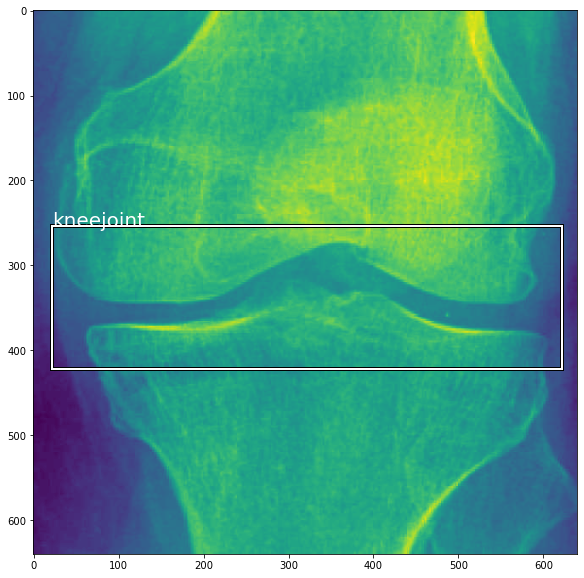

Image id: 5
Image size: (640, 640)


In [48]:
from PIL import Image
import numpy as np
idx = 4
image, xyxy_bboxes, class_ids, image_idx, image_size = ds[idx]
show_image(image, xyxy_bboxes.tolist(), [lookups['class_id_to_label'][int(c)] for c in class_ids])
print(f'Image id: {image_idx}')
print(f'Image size: {image_size}')

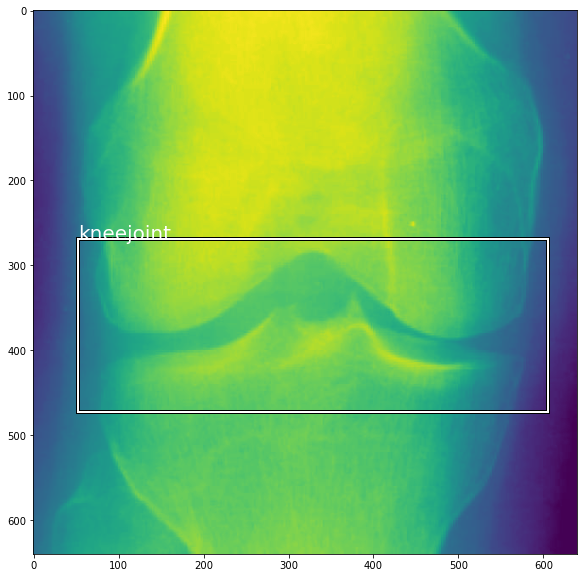

Image id: 12
Image size: (640, 640)


In [49]:
idx = 10
image, xyxy_bboxes, class_ids, image_idx, image_size = ds[idx]
show_image(image, xyxy_bboxes.tolist(), [lookups['class_id_to_label'][int(c)] for c in class_ids])
print(f'Image id: {image_idx}')
print(f'Image size: {image_size}')

# This is where I am having issues.  Albumentations is not working for me or importing properly.  Futhermore, I am having issues when I try to conver this to a tensor through Pytorch it will say not same index.  The errors are below.

In [315]:
# # !pip install albumentations
# import albumentations as A
# import numpy as np
# import torch
# import torchvision
# from torch.utils.data import Dataset


# def yolov7_collate_fn(batch):
#     images, labels, indices, image_sizes = zip(*batch)
#     for i, l in enumerate(labels):
#         l[:, 0] = i  # add target image index for build_targets() in loss fn
#     return (
#         torch.stack(images, 0),
#         torch.cat(labels, 0),
#         torch.stack(indices, 0),
#         torch.stack(image_sizes, 0),
#     )


# def create_base_transforms(target_image_size):
#     return A.Compose(
#         [
#             A.LongestMaxSize(target_image_size),
#         ],
#         bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"]),
#     )


# def create_yolov7_transforms(
#     image_size=(640, 640),
#     training=False,
#     training_transforms=(A.HorizontalFlip(p=0.5),),
# ):
#     transforms = [
#         A.LongestMaxSize(max(image_size)),
#         A.PadIfNeeded(
#             image_size[0],
#             image_size[1],
#             border_mode=0,
#             value=(114, 114, 114),
#         ),
#     ]

#     if training:
#         transforms.extend(training_transforms)

#     return A.Compose(
#         transforms,
#         bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"]),
#     )


# def convert_xyxy_to_cxcywh(bboxes):
#     bboxes = bboxes.copy()
#     bboxes[:, 2] = bboxes[:, 2] - bboxes[:, 0]
#     bboxes[:, 3] = bboxes[:, 3] - bboxes[:, 1]
#     bboxes[:, 0] = bboxes[:, 0] + bboxes[:, 2] * 0.5
#     bboxes[:, 1] = bboxes[:, 1] + bboxes[:, 3] * 0.5
#     return bboxes


# class Yolov7Dataset(Dataset):
#     """
#     A dataset which takes an object detection dataset returning (image, boxes, classes, image_id, image_hw)
#     and applies the necessary preprocessing steps as required by Yolov7 models.
#     By default, this class expects the image, boxes (N, 4) and classes (N,) to be numpy arrays,
#     with the boxes in (x1,y1,x2,y2) format, but this behaviour can be modified by
#     overriding the `load_from_dataset` method.
#     """

#     def __init__(self, dataset, transforms=None):
#         self.ds = dataset
#         self.transforms = transforms

#     def __len__(self):
#         return len(self.ds)

#     def load_from_dataset(self, index):
#         image, boxes, classes, image_id, shape = self.ds[index]
#         return image, boxes, classes, image_id, shape

#     def __getitem__(self, index):
#         image, boxes, classes, image_id, original_image_size = self.load_from_dataset(
#             index
#         )

#         if self.transforms is not None:
#             transformed = self.transforms(image=image, bboxes=boxes, labels=classes)
#             image = transformed["image"]
#             boxes = np.array(transformed["bboxes"])
#             classes = np.array(transformed["labels"])

#         image = image / 255  # 0 - 1 range

#         if len(boxes) != 0:
#             # filter boxes with 0 area in any dimension
#             valid_boxes = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])
#             boxes = boxes[valid_boxes]
#             classes = classes[valid_boxes]

#             boxes = torchvision.ops.box_convert(
#                 torch.as_tensor(boxes, dtype=torch.float32), "xyxy", "cxcywh"
#             )
#             boxes[:, [1, 3]] /= image.shape[0]  # normalized height 0-1
#             boxes[:, [0, 2]] /= image.shape[1]  # normalized width 0-1
#             classes = np.expand_dims(classes, 1)

#             labels_out = torch.hstack(
#                 (
#                     torch.zeros((len(boxes), 1)),
#                     torch.as_tensor(classes, dtype=torch.float32),
#                     boxes,
#                 )
#             )
#         else:
#             labels_out = torch.zeros((0, 6))

#         try:
#             if len(image_id) > 0:
#                 image_id_tensor = torch.as_tensor([])

#         except TypeError:
#             image_id_tensor = torch.as_tensor(image_id)

#         return (
#             torch.as_tensor(image.transpose(2, 0, 1), dtype=torch.float32),
#             labels_out,
#             image_id_tensor,
#             torch.as_tensor(original_image_size),
#         )

ImportError: cannot import name 'Concatenate' from 'typing_extensions' (/Users/huntersylvester/opt/anaconda3/lib/python3.8/site-packages/typing_extensions.py)

In [50]:
# This is the same code as above, but now I have removed any albumentations
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset

def yolov7_collate_fn(batch):
    images, labels, indices, image_sizes = zip(*batch)
    for i, l in enumerate(labels):
        l[:, 0] = i  # add target image index for build_targets() in loss fn
    return (
        torch.stack(images, 0),
        torch.cat(labels, 0),
        torch.stack(indices, 0),
        torch.stack(image_sizes, 0),
    )

def convert_xyxy_to_cxcywh(bboxes):
    bboxes = bboxes.copy()
    bboxes[:, 2] = bboxes[:, 2] - bboxes[:, 0]
    bboxes[:, 3] = bboxes[:, 3] - bboxes[:, 1]
    bboxes[:, 0] = bboxes[:, 0] + bboxes[:, 2] * 0.5
    bboxes[:, 1] = bboxes[:, 1] + bboxes[:, 3] * 0.5
    return bboxes

class Yolov7Dataset():
    """
    A dataset which takes an object detection dataset returning (image, boxes, classes, image_id, image_hw)
    and applies the necessary preprocessing steps as required by Yolov7 models.
    By default, this class expects the image, boxes (N, 4) and classes (N,) to be numpy arrays,
    with the boxes in (x1,y1,x2,y2) format, but this behaviour can be modified by
    overriding the `load_from_dataset` method.
    """

    def __init__(self, dataset, transforms=None):
        self.ds = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.ds)

    def load_from_dataset(self, index):
        image, boxes, classes, image_id, shape = self.ds[index]
        return image, boxes, classes, image_id, shape

    def __getitem__(self, index):
        image, boxes, classes, image_id, original_image_size = self.load_from_dataset(
            index
        )

        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes, labels=classes)
            image = transformed["image"]
            boxes = np.array(transformed["bboxes"])
            classes = np.array(transformed["labels"])

        image = image / 255  # 0 - 1 range

        if len(boxes) != 0:
            # filter boxes with 0 area in any dimension
            valid_boxes = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])
            boxes = boxes[valid_boxes]
            classes = classes[valid_boxes]

            boxes = torchvision.ops.box_convert(
                torch.as_tensor(boxes, dtype=torch.float32), "xyxy", "cxcywh"
            )
            boxes[:, [1, 3]] /= image.shape[0]  # normalized height 0-1
            boxes[:, [0, 2]] /= image.shape[1]  # normalized width 0-1
            classes = np.expand_dims(classes, 1)

            labels_out = torch.hstack(
                (
                    torch.zeros((len(boxes), 1)),
                    torch.as_tensor(classes, dtype=torch.float32),
                    boxes,
                )
            )
        else:
            labels_out = torch.zeros((0, 6))

        try:
            if len(image_id) > 0:
                image_id_tensor = torch.as_tensor([])

        except TypeError:
            image_id_tensor = torch.as_tensor(image_id)

        return (
            torch.as_tensor(image.transpose(2, 0, 1), dtype=torch.float32),
            labels_out,
            image_id_tensor,
            torch.as_tensor(original_image_size),
        )

In [51]:
yolo_ds = Yolov7Dataset(ds)

In [52]:
idx = 4
image_tensor, labels, image_id, image_size = yolo_ds[idx]

print(f'Image: {image_tensor.shape}')
print(f'Labels: {labels}')

# denormalize boxes
boxes = labels[:, 2:]
boxes[:, [0, 2]] *= image_size[1]
boxes[:, [1, 3]] *= image_size[0]

show_image(image_tensor.permute( 1, 2, 0), boxes.tolist(), [lookups['class_id_to_label'][int(c)] for c in labels[:, 1]], 'cxcywh')
print(f'Image id: {image_id}')
print(f'Image size: {image_size}')

ValueError: axes don't match array

In [342]:
import albumentations as A

ImportError: cannot import name 'Concatenate' from 'typing_extensions' (/Users/huntersylvester/opt/anaconda3/lib/python3.8/site-packages/typing_extensions.py)